In [92]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [94]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('sentiment_dataset (1).csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
1588315,4,2191062746,Tue Jun 16 04:25:53 PDT 2009,NO_QUERY,scampateer001,where's the time gone? playing bike ralley on ...
1029943,4,1932847618,Tue May 26 22:21:39 PDT 2009,NO_QUERY,bandwagonknick,"@johnschuhmann Hey John, keep up the great wor..."
822383,4,1554525208,Sat Apr 18 17:14:02 PDT 2009,NO_QUERY,nikki_scene,Just finished eatin tired and needs a nap
1375174,4,2051545130,Fri Jun 05 22:16:18 PDT 2009,NO_QUERY,marismith,@HubieGoode hehe - well thanks for the tip on ...
1397672,4,2053996005,Sat Jun 06 06:17:07 PDT 2009,NO_QUERY,fivewithflores,@justinbrooke Followed


In [95]:
df. shape

(1600000, 6)

In [96]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

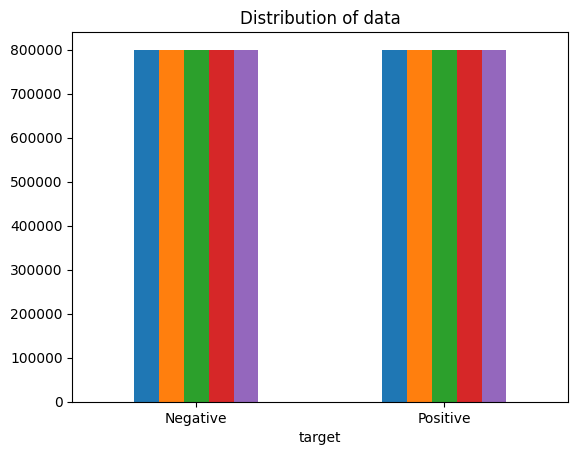

In [97]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

C:\Users\123\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\123\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\123\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='target', ylabel='count'>

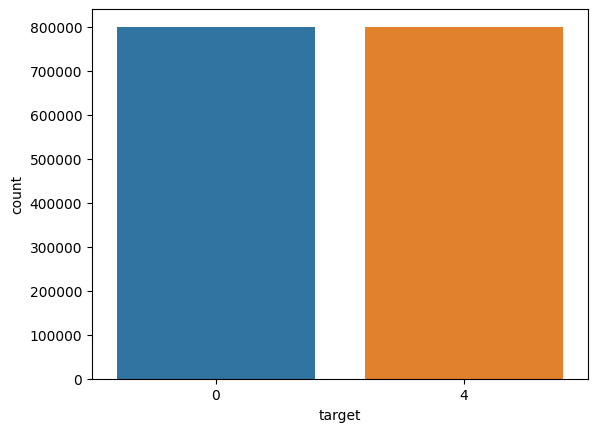

In [98]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [99]:
data=df[['text','target']]

In [100]:
data['target'] = data['target'].replace(4,1)

C:\Users\123\AppData\Local\Temp\ipykernel_6080\2499609609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [101]:
data['target'].unique()

array([0, 1], dtype=int64)

In [102]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [103]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [104]:
dataset = pd.concat([data_pos, data_neg])

In [105]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [106]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [107]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [108]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [109]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [110]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [111]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [112]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [113]:
#stemming
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [114]:
# lm = nltk.WordNetLemmatizer()
# def lemmatizer_on_text(data):
#     text = [lm.lemmatize(word) for word in data]
#     return data
# dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
# dataset['text'].head()

In [115]:
X=data.text
y=data.target

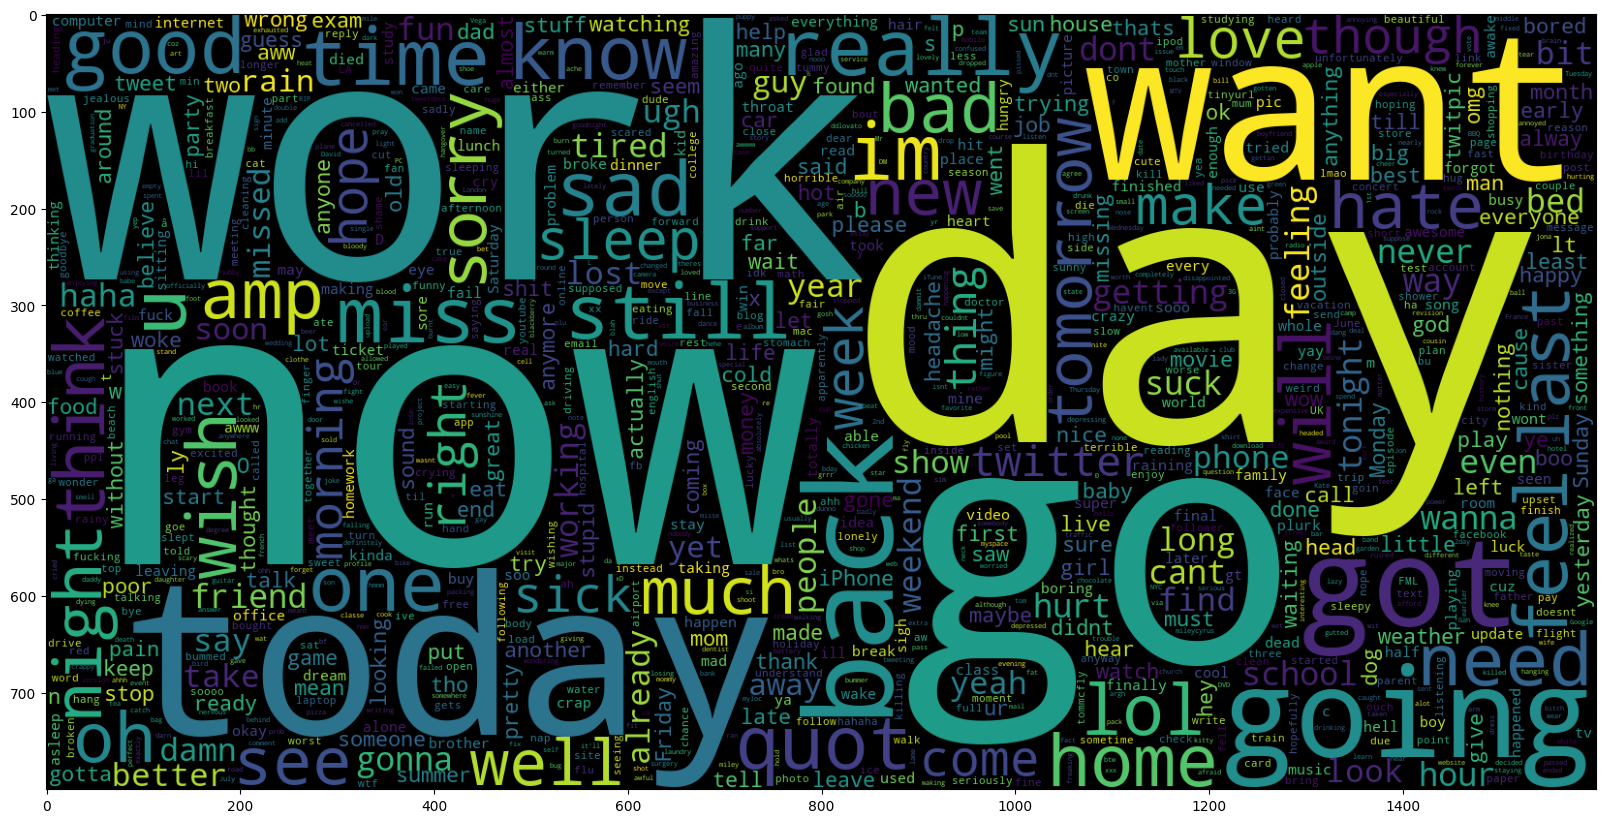

In [116]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

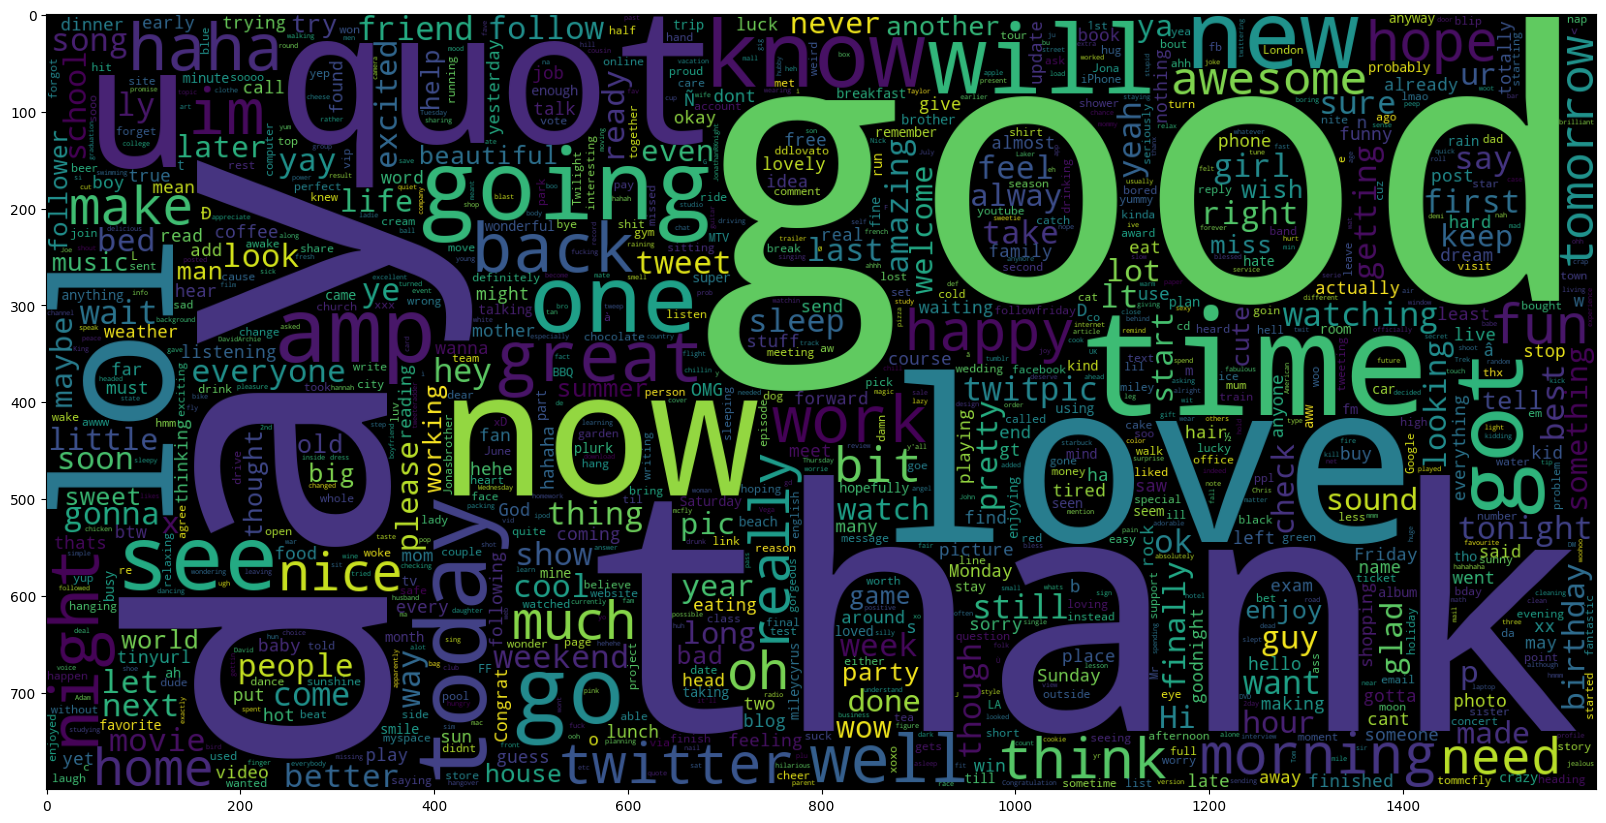

In [117]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [118]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [119]:


vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))


No. of feature_words:  500000


In [124]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming X_train and X_test are lists of strings representing text data

# Initialize the CountVectorizer
vectoriser = CountVectorizer()

# Fit the vectorizer on the training data
vectoriser.fit(X_train)

# Transform both training and test data
X_train_vectorized = vectoriser.transform(X_train)
X_test_vectorized = vectoriser.transform(X_test)


In [125]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [128]:
from sklearn.metrics import classification_report

def model_Evaluate(model, X_test, y_test):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

# Assuming X_train and X_test are lists of strings representing text data
# Assuming y_train and y_test are the corresponding target labels

# Initialize the CountVectorizer with binary=True
vectorizer = CountVectorizer(binary=True)

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_vectorized = vectorizer.transform(X_test)

# Initialize and train the Bernoulli Naive Bayes model
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_vectorized, y_train)

# Evaluate the model and make predictions
model_Evaluate(BNBmodel, X_test_vectorized, y_test)
y_pred1 = BNBmodel.predict(X_test_vectorized)


              precision    recall  f1-score   support

           0       0.77      0.81      0.79     40100
           1       0.80      0.76      0.78     39900

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



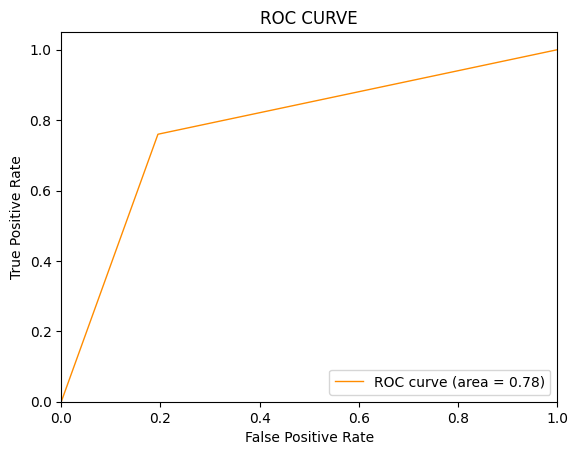

In [129]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [132]:
# Sample tweet
sample_tweet = "Need a hug"

# Preprocess the sample tweet (you should use the same preprocessing steps as used for the training data)
# For simplicity, let's assume you've already preprocessed the sample tweet

# Transform the preprocessed sample tweet into numerical features using the same vectorizer
sample_tweet_vectorized = vectorizer.transform([sample_tweet])

# Predict the sentiment label of the sample tweet using the trained BNB model
predicted_label = BNBmodel.predict(sample_tweet_vectorized)

# Print the predicted label
print("Predicted sentiment label:", predicted_label)


Predicted sentiment label: [0]
